In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="HoleEffect")

/tmp/ipykernel_757843/3431087781.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


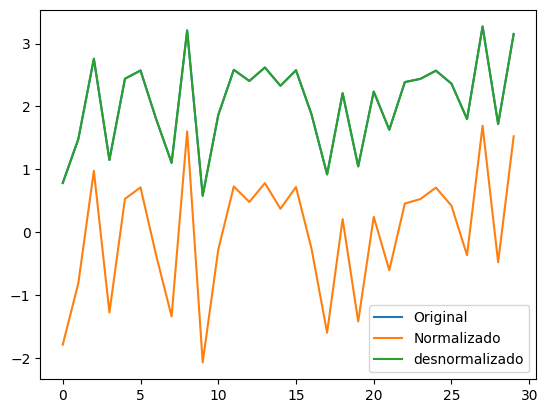

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:21:04.241689: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:21:04.273428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:21:04.273464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:21:04.274444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:21:04.280018: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:21:04.280874: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:21:05.348031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.593315,0.465276,0.465693,0.581796,0.137284,0.317435,0.374293,0.086840,0.186984,0.370519,0.180275,0.373402,133.971403,320.361142
model_1_0_8,0.504529,0.349418,0.364253,0.584962,0.167256,0.386213,0.445354,0.086183,0.219581,0.408969,0.001316,0.412152,133.576462,319.966201
model_1_0_7,0.497701,0.348206,0.362033,0.573906,0.169561,0.386933,0.446909,0.088478,0.221119,0.411777,-0.012446,0.414982,133.549090,319.938830
model_1_0_6,0.421159,0.303262,0.295799,0.518872,0.195399,0.413614,0.493307,0.099906,0.234233,0.442039,-0.166726,0.445479,133.265426,319.655165
model_1_0_5,0.411667,0.301703,0.300193,0.498363,0.198603,0.414539,0.490229,0.104165,0.235711,0.445649,-0.185859,0.449117,133.232895,319.622634
model_1_0_4,0.393804,0.279932,0.266683,0.486898,0.204633,0.427464,0.513704,0.106546,0.240518,0.452364,-0.221863,0.455884,133.173076,319.562815
model_1_0_3,0.323020,0.275434,0.238097,0.363882,0.228528,0.430134,0.533729,0.132090,0.243210,0.478046,-0.364538,0.481766,132.952197,319.341936
model_1_0_2,0.227021,0.152822,0.145732,0.220849,0.260934,0.502921,0.598433,0.161791,0.277312,0.510817,-0.558035,0.514792,132.686978,319.076717
model_1_0_1,0.221546,0.106609,0.104542,0.366357,0.262782,0.530355,0.627287,0.131576,0.276563,0.512623,-0.569072,0.516612,132.672860,319.062599
model_1_0_0,0.070297,-0.028453,0.018886,0.017352,0.313839,0.610534,0.687291,0.204047,0.306494,0.560213,-0.873932,0.564573,132.317751,318.707491


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.846187,0.538056,0.504104,0.809372,0.051922,0.274230,0.347385,0.066448,0.117114,0.227865,0.689971,0.229638,135.916011,322.305750
model_1_1_8,0.841066,0.535217,0.502779,0.804134,0.053651,0.275915,0.348314,0.068274,0.119233,0.231627,0.679649,0.233430,135.850504,322.240243
model_1_1_7,0.826534,0.527415,0.498729,0.791626,0.058557,0.280547,0.351151,0.072634,0.124947,0.241985,0.650358,0.243868,135.675519,322.065259
model_1_1_6,0.802425,0.516739,0.495112,0.766880,0.066695,0.286885,0.353685,0.081260,0.134268,0.258254,0.601763,0.260264,135.415244,321.804983
model_1_1_5,0.787042,0.509876,0.490327,0.762742,0.071888,0.290959,0.357037,0.082702,0.139724,0.268119,0.570757,0.270206,135.265293,321.655033
model_1_1_4,0.745236,0.501558,0.505557,0.711531,0.086000,0.295897,0.346368,0.100553,0.151933,0.293258,0.486491,0.295541,134.906805,321.296544
model_1_1_2,0.660441,0.499124,0.499471,0.607925,0.114625,0.297342,0.350631,0.136667,0.169876,0.338563,0.315575,0.341198,134.332183,320.721922
model_1_1_3,0.663231,0.489155,0.482702,0.603837,0.113683,0.303260,0.362378,0.138092,0.168965,0.337169,0.321201,0.339793,134.348689,320.738428
model_1_1_1,0.638896,0.488717,0.492091,0.579990,0.121897,0.303520,0.355801,0.146405,0.175491,0.349138,0.272151,0.351855,134.209151,320.598891
model_1_1_0,0.630639,0.483739,0.484599,0.571690,0.124685,0.306475,0.361049,0.149298,0.177280,0.353108,0.255506,0.355855,134.163931,320.553670


DataFrame salvo em ../results/metrics_1_1


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  32
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_8,0.944077,0.590597,0.518019,0.856730,0.018878,0.243039,0.337638,0.034179,0.065830,0.137397,0.887280,0.138466,137.939524,324.329263
model_1_2_7,0.943464,0.590331,0.518152,0.856815,0.019085,0.243197,0.337544,0.034159,0.066327,0.138148,0.886044,0.139223,137.917720,324.307459
model_1_2_9,0.944398,0.589351,0.515879,0.855559,0.018770,0.243779,0.339137,0.034459,0.065648,0.137002,0.887926,0.138069,137.951027,324.340767
model_1_2_6,0.918005,0.570547,0.506808,0.840356,0.027679,0.254942,0.345491,0.038085,0.083721,0.166370,0.834729,0.167664,137.174172,323.563911
model_1_2_5,0.915429,0.569420,0.506473,0.838303,0.028548,0.255611,0.345726,0.038575,0.085159,0.168963,0.829537,0.170278,137.112302,323.502041
model_1_2_4,0.911460,0.567645,0.506436,0.835317,0.029888,0.256665,0.345752,0.039288,0.087340,0.172882,0.821537,0.174228,137.020582,323.410321
model_1_2_3,0.910089,0.567028,0.506416,0.834438,0.030351,0.257031,0.345766,0.039497,0.088089,0.174216,0.818773,0.175572,136.989835,323.379575
model_1_2_2,0.898054,0.562351,0.509515,0.828022,0.034414,0.259808,0.343595,0.041028,0.094301,0.185510,0.794515,0.186953,136.738595,323.128335
model_1_2_0,0.884609,0.557848,0.509888,0.818639,0.038953,0.262480,0.343334,0.043266,0.100583,0.197364,0.767414,0.198900,136.490820,322.880559
model_1_2_1,0.886250,0.557218,0.508536,0.819398,0.038398,0.262854,0.344281,0.043085,0.099966,0.195955,0.770723,0.197480,136.519477,322.909216


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.970739,0.613755,0.557057,0.977183,0.009878,0.229292,0.310291,0.008869,0.049040,0.099386,0.941021,0.100159,139.234986,325.624725
model_1_3_8,0.963715,0.610347,0.554182,0.976925,0.012249,0.231315,0.312304,0.008969,0.054427,0.110673,0.926864,0.111534,138.804694,325.194433
model_1_3_7,0.962845,0.609801,0.553876,0.976712,0.012542,0.231639,0.312519,0.009052,0.054960,0.111992,0.925110,0.112864,138.757309,325.147048
model_1_3_6,0.961784,0.609193,0.553088,0.976181,0.012901,0.232000,0.313071,0.009259,0.055651,0.113581,0.922971,0.114465,138.700966,325.090706
model_1_3_5,0.961339,0.609039,0.552793,0.976060,0.013051,0.232091,0.313278,0.009306,0.055869,0.114240,0.922073,0.115130,138.677798,325.067538
model_1_3_4,0.958845,0.606681,0.550142,0.974680,0.013893,0.233491,0.315135,0.009842,0.057570,0.117868,0.917046,0.118785,138.552767,324.942507
model_1_3_2,0.951075,0.599681,0.544113,0.970476,0.016515,0.237646,0.319358,0.011477,0.062840,0.128512,0.901386,0.129513,138.206918,324.596657
model_1_3_3,0.951184,0.599015,0.543054,0.970042,0.016479,0.238042,0.320100,0.011645,0.062847,0.128370,0.901605,0.129369,138.211365,324.601105
model_1_3_1,0.945576,0.592154,0.520745,0.965282,0.018372,0.242115,0.335728,0.013495,0.065115,0.135543,0.890302,0.136597,137.993877,324.383616
model_1_3_0,0.944739,0.591008,0.519396,0.964890,0.018655,0.242796,0.336673,0.013648,0.065617,0.136582,0.888614,0.137645,137.963330,324.353069


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  36
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 32ms/step


 1/32 [..............................] - ETA: 1s

13/32 [===========>..................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.985075,0.636440,0.600455,0.979289,0.005038,0.215825,0.279889,0.008359,0.036585,0.070980,0.969917,0.071533,140.581408,326.971147
model_1_4_8,0.984567,0.634890,0.598666,0.979071,0.005210,0.216745,0.281143,0.008447,0.037247,0.072177,0.968894,0.072739,140.514526,326.904265
model_1_4_7,0.984486,0.634629,0.598304,0.979049,0.005237,0.216900,0.281396,0.008456,0.037328,0.072368,0.968729,0.072931,140.503985,326.893725
model_1_4_6,0.984371,0.634296,0.597898,0.978997,0.005276,0.217097,0.281681,0.008477,0.037462,0.072635,0.968498,0.073200,140.489227,326.878967
model_1_4_5,0.984193,0.633860,0.597477,0.978873,0.005336,0.217357,0.281976,0.008527,0.037711,0.073047,0.968139,0.073616,140.466594,326.856334
model_1_4_4,0.984018,0.633427,0.597061,0.978745,0.005395,0.217614,0.282267,0.008579,0.037965,0.073452,0.967786,0.074023,140.444516,326.834255
model_1_4_3,0.983857,0.632987,0.596601,0.978660,0.005449,0.217875,0.282589,0.008613,0.038193,0.073820,0.967462,0.074395,140.424492,326.814231
model_1_4_2,0.983705,0.632588,0.596201,0.978586,0.005501,0.218112,0.282869,0.008643,0.038399,0.074167,0.967155,0.074744,140.405769,326.795509
model_1_4_1,0.977118,0.619820,0.558936,0.973394,0.007724,0.225691,0.308974,0.010738,0.046253,0.087889,0.953878,0.088573,139.726738,326.116477
model_1_4_0,0.973895,0.618516,0.556095,0.975116,0.008812,0.226465,0.310965,0.010043,0.045644,0.093873,0.947383,0.094604,139.463251,325.852990


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 55ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.988040,0.641999,0.604242,0.990039,0.004037,0.212525,0.277237,0.002880,0.032093,0.063541,0.975892,0.064036,141.024262,327.414001
model_1_5_8,0.987897,0.641678,0.604018,0.990036,0.004086,0.212715,0.277393,0.002881,0.032342,0.063919,0.975605,0.064416,141.000560,327.390300
model_1_5_7,0.987627,0.641133,0.603682,0.990033,0.004177,0.213039,0.277629,0.002882,0.032799,0.064629,0.975060,0.065132,140.956372,327.346111
model_1_5_6,0.987472,0.640814,0.603471,0.990021,0.004229,0.213228,0.277776,0.002886,0.033063,0.065031,0.974749,0.065537,140.931572,327.321311
model_1_5_5,0.987165,0.640430,0.603667,0.990153,0.004333,0.213456,0.277639,0.002847,0.033527,0.065823,0.974130,0.066335,140.883174,327.272913
model_1_5_4,0.987002,0.640107,0.603465,0.990129,0.004388,0.213648,0.277781,0.002855,0.033791,0.066240,0.973801,0.066755,140.857906,327.247645
model_1_5_3,0.986834,0.639771,0.603236,0.990099,0.004444,0.213847,0.277942,0.002863,0.034058,0.066666,0.973463,0.067185,140.832259,327.221998
model_1_5_2,0.986536,0.639155,0.602752,0.990064,0.004545,0.214213,0.278280,0.002873,0.034500,0.067417,0.972861,0.067942,140.787416,327.177155
model_1_5_1,0.985713,0.637662,0.601642,0.989917,0.004823,0.215100,0.279058,0.002916,0.035653,0.069447,0.971203,0.069987,140.668771,327.058510
model_1_5_0,0.985507,0.637324,0.601367,0.989828,0.004892,0.215300,0.279251,0.002941,0.035947,0.069946,0.970787,0.070490,140.640119,327.029858


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.989230,0.642529,0.602460,0.988658,0.003636,0.212210,0.278485,0.004689,0.029949,0.060295,0.978292,0.060765,141.234005,327.623744
model_1_6_1,0.989305,0.640121,0.597555,0.987857,0.003610,0.213640,0.281921,0.005020,0.029953,0.060086,0.978443,0.060554,141.247913,327.637652
model_1_6_2,0.989458,0.638731,0.594255,0.987244,0.003559,0.214465,0.284233,0.005273,0.029704,0.059655,0.978751,0.060119,141.276727,327.666466
model_1_6_3,0.989588,0.638643,0.593714,0.987198,0.003515,0.214517,0.284612,0.005292,0.029483,0.059285,0.979014,0.059746,141.301615,327.691354
model_1_6_4,0.989635,0.638567,0.593467,0.987159,0.003499,0.214562,0.284785,0.005308,0.029406,0.059153,0.979107,0.059613,141.310517,327.700256
model_1_6_5,0.990295,0.638301,0.592183,0.987184,0.003276,0.214720,0.285684,0.005298,0.028213,0.057236,0.980439,0.057681,141.442299,327.832039
model_1_6_7,0.990384,0.638157,0.591696,0.987153,0.003246,0.214806,0.286025,0.005311,0.028043,0.056975,0.980618,0.057418,141.460601,327.850340
model_1_6_6,0.990321,0.638146,0.591816,0.987138,0.003267,0.214812,0.285942,0.005317,0.028167,0.057162,0.980490,0.057606,141.447492,327.837231
model_1_6_9,0.990769,0.637992,0.590576,0.987205,0.003116,0.214903,0.286810,0.005289,0.027250,0.055823,0.981393,0.056257,141.542291,327.932030
model_1_6_8,0.990631,0.637906,0.590731,0.987150,0.003163,0.214954,0.286701,0.005312,0.027548,0.056237,0.981116,0.056674,141.512733,327.902472


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.990710,0.637992,0.592648,0.983607,0.003136,0.214904,0.285358,0.005808,0.025139,0.055999,0.981275,0.056435,141.529662,327.919401
model_1_7_1,0.990510,0.637858,0.592857,0.982377,0.003203,0.214983,0.285212,0.006243,0.025125,0.056599,0.980872,0.057040,141.487049,327.876788
model_1_7_3,0.990270,0.637800,0.593075,0.980817,0.003285,0.215018,0.285060,0.006796,0.025029,0.057311,0.980388,0.057757,141.437046,327.826785
model_1_7_2,0.990376,0.637799,0.592931,0.981523,0.003249,0.215018,0.285160,0.006546,0.025083,0.056997,0.980602,0.057440,141.459042,327.848781
model_1_7_4,0.988365,0.636202,0.593156,0.971135,0.003927,0.215966,0.285003,0.010226,0.025542,0.062670,0.976549,0.063157,141.079512,327.469251
model_1_7_5,0.988152,0.635960,0.592899,0.969942,0.004000,0.216110,0.285182,0.010649,0.025536,0.063242,0.976118,0.063735,141.043122,327.432861
model_1_7_6,0.986790,0.634892,0.591874,0.962113,0.004459,0.216744,0.285901,0.013422,0.025307,0.066778,0.973374,0.067298,140.825532,327.215271
model_1_7_7,0.986652,0.634842,0.591811,0.961246,0.004506,0.216773,0.285945,0.013729,0.025244,0.067127,0.973095,0.067649,140.804697,327.194436
model_1_7_8,0.986516,0.634774,0.591707,0.960416,0.004552,0.216814,0.286018,0.014024,0.025193,0.067466,0.972822,0.067991,140.784547,327.174286
model_1_7_9,0.986375,0.634680,0.591582,0.959579,0.004599,0.216870,0.286106,0.014320,0.025159,0.067819,0.972537,0.068347,140.763633,327.153372


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 75ms/step


 1/32 [..............................] - ETA: 1s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  32
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.988251,0.633683,0.586618,0.973726,0.003966,0.217462,0.289583,0.007721,0.024344,0.062976,0.976319,0.063467,141.059975,327.449715
model_1_8_1,0.988390,0.633654,0.586300,0.974083,0.003919,0.217479,0.289806,0.007616,0.024265,0.062603,0.976599,0.063090,141.083750,327.473489
model_1_8_2,0.988524,0.633605,0.585949,0.974426,0.003874,0.217508,0.290052,0.007515,0.024192,0.062242,0.976868,0.062726,141.106905,327.496644
model_1_8_3,0.988768,0.633451,0.585147,0.975018,0.003791,0.217599,0.290613,0.007341,0.024082,0.061575,0.977361,0.062054,141.150001,327.539741
model_1_8_4,0.988872,0.633321,0.584708,0.975286,0.003756,0.217677,0.290920,0.007263,0.024057,0.061290,0.977570,0.061767,141.168568,327.558307
model_1_8_5,0.990286,0.631717,0.577568,0.977947,0.003279,0.218629,0.295922,0.006481,0.023162,0.057264,0.980420,0.057709,141.440345,327.830085
model_1_8_6,0.990301,0.631593,0.577254,0.977951,0.003274,0.218703,0.296143,0.006479,0.023246,0.057220,0.980450,0.057665,141.443397,327.833137
model_1_8_7,0.990562,0.630563,0.574049,0.977849,0.003186,0.219314,0.298387,0.006510,0.022997,0.056444,0.980977,0.056883,141.498042,327.887781
model_1_8_8,0.990722,0.630277,0.572591,0.977773,0.003132,0.219483,0.299409,0.006532,0.022781,0.055963,0.981300,0.056399,141.532245,327.921984
model_1_8_9,0.991176,0.627939,0.562940,0.975592,0.002979,0.220872,0.306169,0.007173,0.021761,0.054577,0.982215,0.055002,141.632579,328.022318


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.992651,0.635235,0.573479,0.986965,0.002481,0.216540,0.298787,0.002903,0.021111,0.049809,0.985186,0.050197,141.998229,328.387968
model_1_9_8,0.992616,0.635018,0.573191,0.987200,0.002493,0.216669,0.298988,0.002851,0.021165,0.049925,0.985117,0.050314,141.988933,328.378672
model_1_9_7,0.992579,0.634838,0.573009,0.987417,0.002505,0.216776,0.299116,0.002803,0.021220,0.050052,0.985042,0.050441,141.978802,328.368541
model_1_9_6,0.992466,0.634383,0.572580,0.988076,0.002543,0.217046,0.299417,0.002656,0.021365,0.050431,0.984814,0.050823,141.948617,328.338357
model_1_9_5,0.992428,0.634279,0.572585,0.988263,0.002556,0.217108,0.299413,0.002614,0.021402,0.050558,0.984737,0.050952,141.938498,328.328237
model_1_9_4,0.992296,0.634078,0.573023,0.989305,0.002601,0.217227,0.299106,0.002382,0.021404,0.050996,0.984472,0.051393,141.904033,328.293772
model_1_9_3,0.991743,0.630709,0.567622,0.991822,0.002787,0.219227,0.302890,0.001822,0.021390,0.052795,0.983357,0.053205,141.765389,328.155128
model_1_9_2,0.991667,0.630370,0.567126,0.991975,0.002813,0.219428,0.303237,0.001787,0.021444,0.053037,0.983204,0.053450,141.747028,328.136768
model_1_9_1,0.991593,0.630002,0.566539,0.992133,0.002838,0.219647,0.303649,0.001752,0.021487,0.053271,0.983055,0.053686,141.729432,328.119171
model_1_9_0,0.991513,0.629651,0.566024,0.992277,0.002865,0.219855,0.304009,0.001720,0.021549,0.053525,0.982893,0.053942,141.710396,328.100135


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.993315,0.639337,0.583872,0.988206,0.002257,0.214105,0.291506,0.003923,0.020205,0.047503,0.986526,0.047873,142.187815,328.577554
model_1_10_8,0.993224,0.638523,0.581830,0.988645,0.002287,0.214589,0.292937,0.003777,0.020345,0.047825,0.986343,0.048197,142.160829,328.550568
model_1_10_7,0.993168,0.637992,0.580457,0.988894,0.002306,0.214903,0.293899,0.003694,0.020432,0.048024,0.986229,0.048398,142.144193,328.533932
model_1_10_6,0.993085,0.637471,0.579195,0.989081,0.002334,0.215213,0.294782,0.003632,0.020582,0.048316,0.986061,0.048692,142.119999,328.509739
model_1_10_5,0.993058,0.637329,0.578787,0.989150,0.002343,0.215297,0.295068,0.003609,0.020626,0.048407,0.986009,0.048784,142.112440,328.502179
model_1_10_4,0.993026,0.637141,0.578326,0.989200,0.002354,0.215409,0.295391,0.003592,0.020681,0.048521,0.985942,0.048899,142.103000,328.492739
model_1_10_3,0.992992,0.636924,0.577796,0.989246,0.002366,0.215537,0.295763,0.003577,0.020732,0.048637,0.985875,0.049016,142.093449,328.483188
model_1_10_2,0.992956,0.636754,0.577386,0.989286,0.002378,0.215639,0.296050,0.003564,0.020790,0.048764,0.985801,0.049144,142.083048,328.472787
model_1_10_1,0.992882,0.636416,0.576606,0.989365,0.002403,0.215839,0.296597,0.003538,0.020896,0.049018,0.985653,0.049400,142.062233,328.451972
model_1_10_0,0.992843,0.636273,0.576234,0.989400,0.002416,0.215924,0.296857,0.003526,0.020954,0.049154,0.985573,0.049536,142.051195,328.440934


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.993765,0.641803,0.591793,0.989720,0.002105,0.212641,0.285957,0.003832,0.019559,0.045878,0.987432,0.046235,142.327073,328.716812
model_1_11_8,0.993752,0.641740,0.591574,0.989795,0.002109,0.212678,0.286111,0.003804,0.019573,0.045926,0.987406,0.046283,142.322921,328.712660
model_1_11_7,0.993736,0.641655,0.591299,0.989863,0.002114,0.212729,0.286304,0.003779,0.019591,0.045982,0.987375,0.046340,142.317979,328.707719
model_1_11_6,0.993733,0.641604,0.590949,0.989915,0.002115,0.212760,0.286548,0.003759,0.019564,0.045994,0.987368,0.046352,142.316934,328.706674
model_1_11_5,0.993719,0.641542,0.590707,0.989992,0.002120,0.212796,0.286718,0.003731,0.019576,0.046046,0.987340,0.046405,142.312427,328.702166
model_1_11_4,0.993702,0.641443,0.590400,0.990057,0.002126,0.212855,0.286933,0.003706,0.019592,0.046109,0.987306,0.046467,142.307022,328.696762
model_1_11_3,0.993575,0.640731,0.588296,0.990522,0.002169,0.213278,0.288407,0.003533,0.019753,0.046571,0.987050,0.046933,142.267149,328.656888
model_1_11_2,0.993511,0.640419,0.587383,0.990705,0.002191,0.213463,0.289047,0.003465,0.019861,0.046803,0.986920,0.047167,142.247217,328.636957
model_1_11_1,0.993487,0.640309,0.587055,0.990763,0.002199,0.213528,0.289277,0.003443,0.019909,0.046888,0.986873,0.047253,142.239934,328.629673
model_1_11_0,0.993404,0.639751,0.585076,0.990967,0.002226,0.213859,0.290663,0.003367,0.020047,0.047185,0.986706,0.047552,142.214703,328.604442


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.993810,0.641900,0.592971,0.994862,0.002090,0.212584,0.285132,0.001395,0.019582,0.045713,0.987523,0.046068,142.341521,328.731260
model_1_12_1,0.994007,0.641398,0.591204,0.994462,0.002023,0.212882,0.286370,0.001504,0.019195,0.044978,0.987921,0.045328,142.406332,328.796072
model_1_12_2,0.994062,0.640421,0.589130,0.993949,0.002004,0.213462,0.287823,0.001643,0.019209,0.044771,0.988031,0.045120,142.424738,328.814478
model_1_12_9,0.994448,0.640265,0.586000,0.992528,0.001874,0.213554,0.290016,0.002029,0.018876,0.043293,0.988809,0.043630,142.559032,328.948771
model_1_12_8,0.994438,0.640215,0.586022,0.992575,0.001878,0.213584,0.290001,0.002016,0.018880,0.043332,0.988789,0.043669,142.555461,328.945200
model_1_12_6,0.994320,0.640154,0.586630,0.993077,0.001918,0.213620,0.289574,0.001880,0.018982,0.043789,0.988551,0.044130,142.513466,328.903205
model_1_12_4,0.994286,0.640148,0.587062,0.993231,0.001929,0.213624,0.289271,0.001838,0.019022,0.043920,0.988482,0.044262,142.501559,328.891299
model_1_12_5,0.994301,0.640134,0.586693,0.993113,0.001924,0.213632,0.289530,0.001870,0.019009,0.043861,0.988513,0.044202,142.506956,328.896695
model_1_12_3,0.994162,0.640088,0.587944,0.993571,0.001971,0.213659,0.288654,0.001745,0.019197,0.044392,0.988233,0.044738,142.458742,328.848481
model_1_12_7,0.994389,0.640024,0.585889,0.992678,0.001894,0.213697,0.290093,0.001988,0.018929,0.043521,0.988691,0.043859,142.538084,328.927823


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.994352,0.641459,0.579625,0.989733,0.001907,0.212846,0.294482,0.003868,0.019244,0.043665,0.988616,0.044005,142.524834,328.914573
model_1_13_7,0.994376,0.641443,0.579964,0.989983,0.001899,0.212855,0.294244,0.003774,0.019200,0.043572,0.988664,0.043911,142.533343,328.923082
model_1_13_8,0.994358,0.641401,0.579709,0.989840,0.001905,0.212880,0.294423,0.003828,0.019240,0.043642,0.988628,0.043981,142.526982,328.916721
model_1_13_6,0.994380,0.641106,0.580193,0.990367,0.001897,0.213055,0.294084,0.003629,0.019221,0.043557,0.988672,0.043896,142.534699,328.924438
model_1_13_5,0.994466,0.640907,0.582159,0.991576,0.001868,0.213173,0.292706,0.003174,0.019024,0.043222,0.988846,0.043558,142.565656,328.955396
model_1_13_4,0.994457,0.640834,0.582292,0.991655,0.001871,0.213217,0.292613,0.003144,0.019048,0.043258,0.988827,0.043594,142.562306,328.952045
model_1_13_3,0.994450,0.640714,0.582305,0.991748,0.001873,0.213288,0.292604,0.003109,0.019058,0.043283,0.988814,0.043620,142.559975,328.949714
model_1_13_2,0.994442,0.640655,0.582447,0.991833,0.001876,0.213322,0.292504,0.003077,0.019076,0.043316,0.988797,0.043653,142.556962,328.946702
model_1_13_1,0.994405,0.640484,0.583972,0.992504,0.001889,0.213424,0.291436,0.002824,0.019115,0.043461,0.988722,0.043799,142.543603,328.933342
model_1_13_0,0.994413,0.640278,0.584392,0.992780,0.001886,0.213547,0.291142,0.002720,0.019059,0.043426,0.988740,0.043764,142.546772,328.936511


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_5,0.994621,0.642404,0.584530,0.993818,0.001816,0.212284,0.291045,0.002599,0.019231,0.042612,0.989158,0.042943,142.622501,329.012240
model_1_14_2,0.994653,0.642401,0.583211,0.995203,0.001805,0.212286,0.291969,0.002016,0.019099,0.042484,0.989223,0.042815,142.634507,329.024246
model_1_14_4,0.994652,0.642386,0.583380,0.994981,0.001805,0.212295,0.291851,0.002110,0.019110,0.042490,0.989220,0.042820,142.633980,329.023719
model_1_14_3,0.994645,0.642353,0.583263,0.995064,0.001808,0.212315,0.291933,0.002075,0.019115,0.042516,0.989207,0.042847,142.631529,329.021268
model_1_14_1,0.994538,0.642129,0.581380,0.996284,0.001844,0.212447,0.293252,0.001562,0.019069,0.042938,0.988991,0.043272,142.591977,328.981716
model_1_14_6,0.994464,0.642070,0.585489,0.992206,0.001869,0.212483,0.290373,0.003276,0.019417,0.043228,0.988842,0.043564,142.565067,328.954806
model_1_14_7,0.994364,0.641800,0.585315,0.991458,0.001903,0.212643,0.290495,0.003591,0.019518,0.043618,0.988640,0.043958,142.529100,328.918839
model_1_14_0,0.994433,0.641725,0.580292,0.996574,0.001879,0.212688,0.294014,0.001440,0.019147,0.043348,0.988780,0.043686,142.553943,328.943682
model_1_14_8,0.994283,0.641643,0.585258,0.990875,0.001930,0.212736,0.290536,0.003836,0.019552,0.043930,0.988477,0.044272,142.500643,328.890383
model_1_14_9,0.994207,0.641510,0.584876,0.990356,0.001955,0.212815,0.290803,0.004054,0.019572,0.044221,0.988324,0.044565,142.474235,328.863974


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  38
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  41
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.994554,0.640890,0.588227,0.990448,0.001838,0.213183,0.288456,0.003485,0.019192,0.042877,0.989023,0.043211,142.597695,328.987434
model_1_15_1,0.994575,0.639294,0.588309,0.989069,0.001831,0.214131,0.288398,0.003988,0.019123,0.042793,0.989066,0.043126,142.605566,328.995305
model_1_15_2,0.994575,0.639266,0.588311,0.989032,0.001831,0.214147,0.288396,0.004002,0.019119,0.042792,0.989066,0.043125,142.605595,328.995334
model_1_15_3,0.994570,0.639177,0.588167,0.988998,0.001833,0.214200,0.288497,0.004015,0.019121,0.042812,0.989056,0.043145,142.603755,328.993494
model_1_15_4,0.994559,0.638826,0.588006,0.988707,0.001837,0.214408,0.288610,0.004121,0.019114,0.042857,0.989033,0.043191,142.599530,328.989269
model_1_15_5,0.994558,0.638790,0.588000,0.988670,0.001837,0.214430,0.288614,0.004134,0.019111,0.042861,0.989031,0.043195,142.599173,328.988912
model_1_15_6,0.994546,0.638481,0.587867,0.988415,0.001841,0.214613,0.288708,0.004227,0.019105,0.042908,0.989007,0.043242,142.594765,328.984504
model_1_15_7,0.994543,0.638436,0.587855,0.988375,0.001842,0.214640,0.288716,0.004242,0.019105,0.042918,0.989002,0.043252,142.593824,328.983563
model_1_15_8,0.994521,0.637968,0.587527,0.988069,0.001850,0.214918,0.288946,0.004353,0.019100,0.043008,0.988956,0.043343,142.585494,328.975233
model_1_15_9,0.994517,0.637870,0.587352,0.988045,0.001851,0.214976,0.289069,0.004362,0.019097,0.043023,0.988948,0.043358,142.584052,328.973791


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_0,0.994441,0.637348,0.586095,0.994552,0.001877,0.215286,0.289949,0.001909,0.019252,0.043320,0.988795,0.043657,142.556554,328.946293
model_1_16_1,0.994454,0.635742,0.584074,0.993630,0.001872,0.216239,0.291364,0.002232,0.019504,0.043268,0.988822,0.043604,142.561408,328.951147
model_1_16_2,0.994378,0.635432,0.581560,0.992368,0.001898,0.216423,0.293126,0.002674,0.019490,0.043564,0.988668,0.043903,142.534066,328.923805
model_1_16_4,0.994320,0.635128,0.580482,0.990727,0.001917,0.216604,0.293881,0.003249,0.019526,0.043788,0.988551,0.044129,142.513584,328.903324
model_1_16_3,0.994310,0.634781,0.580738,0.991605,0.001921,0.216810,0.293702,0.002941,0.019766,0.043825,0.988532,0.044167,142.510163,328.899902
model_1_16_5,0.994239,0.634544,0.579977,0.990023,0.001945,0.216950,0.294234,0.003495,0.019773,0.044100,0.988388,0.044443,142.485186,328.874925
model_1_16_9,0.993589,0.633426,0.576351,0.985531,0.002164,0.217614,0.296775,0.005069,0.020226,0.046520,0.987078,0.046882,142.271527,328.661266
model_1_16_7,0.993475,0.632960,0.576308,0.986221,0.002202,0.217891,0.296805,0.004828,0.020476,0.046931,0.986849,0.047296,142.236347,328.626087
model_1_16_8,0.993572,0.632907,0.576211,0.986242,0.002170,0.217922,0.296873,0.004820,0.020359,0.046581,0.987044,0.046943,142.266258,328.655997
model_1_16_6,0.993486,0.632857,0.576000,0.986352,0.002199,0.217952,0.297021,0.004782,0.020471,0.046893,0.986870,0.047258,142.239550,328.629289


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.992752,0.641395,0.600779,0.985015,0.002447,0.212883,0.279663,0.006125,0.019759,0.049463,0.985391,0.049848,142.026114,328.415853
model_1_17_8,0.992782,0.641207,0.600240,0.985238,0.002437,0.212995,0.280040,0.006034,0.019782,0.049363,0.985450,0.049747,142.034213,328.423953
model_1_17_7,0.992850,0.640957,0.599297,0.985640,0.002414,0.213144,0.280701,0.005870,0.019777,0.049128,0.985589,0.049510,142.053298,328.443037
model_1_17_6,0.992858,0.640792,0.598895,0.985774,0.002411,0.213242,0.280982,0.005815,0.019811,0.049101,0.985605,0.049483,142.055517,328.445256
model_1_17_5,0.992930,0.640508,0.598230,0.986191,0.002387,0.213410,0.281448,0.005644,0.019829,0.048853,0.985750,0.049233,142.075794,328.465534
model_1_17_4,0.992965,0.640262,0.597661,0.986458,0.002375,0.213556,0.281847,0.005535,0.019860,0.048732,0.985820,0.049111,142.085665,328.475404
model_1_17_3,0.993456,0.638516,0.591600,0.989053,0.002209,0.214592,0.286093,0.004475,0.019709,0.047001,0.986810,0.047366,142.230387,328.620126
model_1_17_2,0.993560,0.636722,0.586091,0.990378,0.002174,0.215658,0.289952,0.003933,0.019908,0.046626,0.987019,0.046989,142.262412,328.652152
model_1_17_1,0.993559,0.636384,0.585182,0.990509,0.002174,0.215858,0.290589,0.003879,0.019941,0.046629,0.987017,0.046992,142.262112,328.651851
model_1_17_0,0.993540,0.634936,0.580460,0.991211,0.002181,0.216718,0.293896,0.003592,0.020089,0.046697,0.986979,0.047061,142.256260,328.645999


DataFrame salvo em ../results/metrics_1_17


+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.994680,0.642403,0.590590,0.982551,0.001796,0.212285,0.286800,0.003543,0.017833,0.042378,0.989277,0.042707,142.644544,329.034283
model_1_18_8,0.994679,0.642310,0.590675,0.982678,0.001796,0.212340,0.286740,0.003517,0.017852,0.042381,0.989275,0.042711,142.644226,329.033966
model_1_18_7,0.994513,0.641395,0.591180,0.982490,0.001852,0.212884,0.286387,0.003556,0.018132,0.043037,0.988941,0.043372,142.582766,328.972506
model_1_18_0,0.992974,0.641298,0.599761,0.975793,0.002372,0.212941,0.280376,0.004916,0.019651,0.048700,0.985838,0.049079,142.088283,328.478022
model_1_18_6,0.994364,0.641245,0.591953,0.981903,0.001903,0.212972,0.285845,0.003675,0.018285,0.043618,0.988640,0.043957,142.529167,328.918907
model_1_18_1,0.993083,0.641172,0.598874,0.976226,0.002335,0.213016,0.280997,0.004828,0.019541,0.048321,0.986058,0.048697,142.119581,328.509320
model_1_18_5,0.994159,0.641159,0.593210,0.981057,0.001972,0.213024,0.284965,0.003847,0.018505,0.044403,0.988228,0.044748,142.457821,328.847560
model_1_18_4,0.994137,0.641157,0.593445,0.980972,0.001979,0.213025,0.284800,0.003864,0.018526,0.044490,0.988181,0.044836,142.450001,328.839740
model_1_18_3,0.993863,0.640962,0.595466,0.980215,0.002072,0.213141,0.283384,0.004018,0.018894,0.045515,0.987630,0.045869,142.358838,328.748577
model_1_18_2,0.993139,0.640913,0.597815,0.976292,0.002316,0.213169,0.281739,0.004814,0.019462,0.048127,0.986170,0.048502,142.135632,328.525372


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

12/32 [==========>...................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_4,0.994882,0.644415,0.588641,0.990450,0.001728,0.211090,0.288165,0.002719,0.017608,0.041566,0.989684,0.041889,142.721913,329.111652
model_1_19_5,0.994813,0.644222,0.586504,0.988580,0.001751,0.211205,0.289663,0.003251,0.017733,0.041845,0.989545,0.042170,142.695146,329.084886
model_1_19_3,0.994875,0.643996,0.589474,0.991734,0.001730,0.211339,0.287582,0.002353,0.017603,0.041594,0.989670,0.041918,142.719176,329.108916
model_1_19_6,0.994748,0.643988,0.585369,0.987694,0.001773,0.211344,0.290457,0.003503,0.017806,0.042108,0.989413,0.042436,142.670073,329.059812
model_1_19_2,0.994870,0.643918,0.589489,0.991832,0.001732,0.211386,0.287572,0.002325,0.017608,0.041615,0.989659,0.041939,142.717165,329.106904
model_1_19_7,0.994641,0.643613,0.584156,0.986679,0.001809,0.211566,0.291307,0.003792,0.017916,0.042532,0.989199,0.042863,142.630010,329.019750
model_1_19_8,0.994630,0.643583,0.584013,0.986552,0.001813,0.211585,0.291408,0.003828,0.017931,0.042576,0.989176,0.042908,142.625832,329.015571
model_1_19_1,0.994793,0.643200,0.590475,0.992893,0.001758,0.211812,0.286881,0.002023,0.017704,0.041926,0.989504,0.042253,142.687370,329.077109
model_1_19_9,0.994529,0.643188,0.582634,0.985579,0.001847,0.211819,0.292373,0.004105,0.018051,0.042974,0.988973,0.043308,142.588660,328.978400
model_1_19_0,0.994782,0.643068,0.590520,0.992993,0.001762,0.211890,0.286849,0.001995,0.017726,0.041971,0.989482,0.042298,142.683094,329.072834


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_5,0.993514,0.645145,0.581861,0.983974,0.002190,0.210657,0.292915,0.005084,0.018886,0.046792,0.986926,0.047156,142.248150,328.637890
model_1_20_7,0.993450,0.645090,0.581543,0.983526,0.002211,0.210690,0.293138,0.005227,0.018933,0.047022,0.986798,0.047388,142.228577,328.618317
model_1_20_4,0.993576,0.645065,0.581826,0.984368,0.002168,0.210705,0.292939,0.004959,0.018852,0.046567,0.987052,0.046929,142.267459,328.657198
model_1_20_6,0.993498,0.645050,0.581554,0.983839,0.002195,0.210714,0.293130,0.005127,0.018904,0.046851,0.986894,0.047215,142.243169,328.632908
model_1_20_9,0.993301,0.645029,0.581211,0.982621,0.002261,0.210726,0.293370,0.005514,0.019011,0.047555,0.986497,0.047925,142.183460,328.573199
model_1_20_3,0.993630,0.645006,0.581829,0.984719,0.002150,0.210740,0.292937,0.004848,0.018822,0.046372,0.987160,0.046732,142.284280,328.674019
model_1_20_8,0.993442,0.644982,0.581389,0.983457,0.002214,0.210754,0.293246,0.005249,0.018940,0.047050,0.986782,0.047417,142.226147,328.615886
model_1_20_2,0.994087,0.644726,0.582356,0.987629,0.001996,0.210906,0.292568,0.003925,0.018531,0.044679,0.988081,0.045026,142.433042,328.822781
model_1_20_1,0.994534,0.643758,0.582468,0.991375,0.001845,0.211481,0.292490,0.002736,0.018113,0.042957,0.988982,0.043291,142.590235,328.979974
model_1_20_0,0.994539,0.643690,0.582448,0.991508,0.001843,0.211521,0.292504,0.002694,0.018101,0.042935,0.988993,0.043269,142.592317,328.982056


DataFrame salvo em ../results/metrics_1_20


+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  25
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.993489,0.644728,0.580030,0.992474,0.002198,0.210905,0.294197,0.002032,0.018973,0.046883,0.986875,0.047248,142.240361,328.630100
model_1_21_1,0.993763,0.643282,0.577038,0.991754,0.002105,0.211763,0.296294,0.002227,0.019057,0.045884,0.987429,0.046241,142.326545,328.716284
model_1_21_2,0.993833,0.642792,0.575955,0.991535,0.002082,0.212054,0.297053,0.002286,0.019039,0.045627,0.987570,0.045982,142.349042,328.738782
model_1_21_3,0.993836,0.642500,0.575505,0.991463,0.002081,0.212228,0.297368,0.002305,0.019021,0.045614,0.987577,0.045969,142.350186,328.739926
model_1_21_4,0.993859,0.642433,0.575315,0.991364,0.002073,0.212267,0.297501,0.002332,0.019018,0.045531,0.987622,0.045885,142.357491,328.747231
model_1_21_5,0.994104,0.640680,0.572015,0.989103,0.001990,0.213308,0.299812,0.002943,0.018992,0.044615,0.988115,0.044962,142.438764,328.828504
model_1_21_6,0.994111,0.640174,0.571134,0.988575,0.001988,0.213609,0.300430,0.003085,0.019001,0.044587,0.988130,0.044934,142.441252,328.830992
model_1_21_7,0.994109,0.640041,0.570905,0.988435,0.001989,0.213687,0.300590,0.003123,0.019002,0.044593,0.988127,0.044940,142.440737,328.830476
model_1_21_8,0.994108,0.639935,0.570716,0.988282,0.001989,0.213750,0.300723,0.003164,0.019009,0.044598,0.988124,0.044946,142.440221,328.829960
model_1_21_9,0.994103,0.639707,0.570377,0.987974,0.001991,0.213885,0.300960,0.003248,0.019023,0.044616,0.988114,0.044963,142.438694,328.828433


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++

Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.994540,0.645484,0.581865,0.995678,0.001843,0.210456,0.292912,0.001938,0.019183,0.042933,0.988994,0.043267,142.592432,328.982171
model_1_22_8,0.994497,0.644464,0.579832,0.996206,0.001858,0.211062,0.294336,0.001701,0.019158,0.043099,0.988909,0.043435,142.576991,328.966730
model_1_22_7,0.994535,0.643962,0.578114,0.996689,0.001845,0.211359,0.295540,0.001484,0.019089,0.042952,0.988984,0.043286,142.590669,328.980409
model_1_22_6,0.994487,0.643729,0.578093,0.996937,0.001861,0.211498,0.295554,0.001373,0.019270,0.043140,0.988888,0.043475,142.573242,328.962981
model_1_22_5,0.994401,0.642536,0.575691,0.997379,0.001890,0.212206,0.297237,0.001175,0.019264,0.043476,0.988714,0.043814,142.542188,328.931927
model_1_22_4,0.994211,0.640275,0.572028,0.997792,0.001954,0.213548,0.299803,0.000990,0.019060,0.044208,0.988331,0.044552,142.475406,328.865145
model_1_22_3,0.994181,0.639901,0.571254,0.997830,0.001964,0.213770,0.300345,0.000973,0.019051,0.044319,0.988272,0.044664,142.465346,328.855085
model_1_22_2,0.994151,0.639646,0.570847,0.997862,0.001974,0.213921,0.300631,0.000958,0.019056,0.044434,0.988211,0.044780,142.454976,328.844715
model_1_22_1,0.994126,0.639494,0.570496,0.997902,0.001983,0.214012,0.300876,0.000941,0.019062,0.044528,0.988161,0.044874,142.446560,328.836299
model_1_22_0,0.994098,0.639309,0.570201,0.997942,0.001992,0.214122,0.301083,0.000923,0.019057,0.044635,0.988104,0.044983,142.436911,328.826650


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.994722,0.649038,0.594976,0.987585,0.001782,0.208346,0.283728,0.003923,0.018970,0.042211,0.989361,0.042540,142.660252,329.049991
model_1_23_8,0.994716,0.649005,0.594808,0.987642,0.001784,0.208366,0.283846,0.003905,0.018978,0.042235,0.989349,0.042564,142.658004,329.047744
model_1_23_7,0.994715,0.648968,0.594485,0.987802,0.001784,0.208388,0.284072,0.003855,0.018973,0.042239,0.989347,0.042567,142.657675,329.047414
model_1_23_6,0.994708,0.648909,0.594294,0.987863,0.001786,0.208423,0.284205,0.003836,0.018977,0.042265,0.989334,0.042593,142.655226,329.044965
model_1_23_4,0.994696,0.648847,0.593955,0.987986,0.001791,0.208460,0.284443,0.003797,0.018986,0.042315,0.989309,0.042644,142.650444,329.040184
model_1_23_5,0.994704,0.648837,0.594026,0.987933,0.001788,0.208466,0.284393,0.003814,0.018979,0.042282,0.989325,0.042611,142.653608,329.043347
model_1_23_3,0.994665,0.648010,0.591527,0.988560,0.001801,0.208957,0.286144,0.003615,0.018991,0.042437,0.989247,0.042767,142.638926,329.028665
model_1_23_2,0.994657,0.647697,0.590663,0.988733,0.001804,0.209142,0.286749,0.003561,0.018984,0.042470,0.989230,0.042801,142.635805,329.025544
model_1_23_1,0.994608,0.646277,0.586303,0.989668,0.001820,0.209985,0.289803,0.003265,0.019020,0.042664,0.989132,0.042996,142.617626,329.007366
model_1_23_0,0.994566,0.645437,0.582143,0.990565,0.001834,0.210484,0.292717,0.002982,0.019138,0.042829,0.989047,0.043163,142.602120,328.991859


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  29
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_0,0.994739,0.648978,0.596023,0.995422,0.001776,0.208382,0.282994,0.001379,0.018939,0.042141,0.989396,0.042469,142.666906,329.056646
model_1_24_1,0.994762,0.648842,0.595924,0.995363,0.001768,0.208463,0.283063,0.001397,0.018905,0.042049,0.989443,0.042376,142.675674,329.065413
model_1_24_2,0.994758,0.648247,0.595111,0.995283,0.001769,0.208816,0.283633,0.001421,0.018854,0.042065,0.989435,0.042392,142.674184,329.063923
model_1_24_3,0.994781,0.648194,0.595152,0.995219,0.001762,0.208847,0.283605,0.001440,0.018830,0.041972,0.989481,0.042299,142.683011,329.072750
model_1_24_4,0.994819,0.648012,0.595067,0.995071,0.001749,0.208955,0.283664,0.001485,0.018801,0.041819,0.989558,0.042144,142.697624,329.087363
model_1_24_5,0.994839,0.647958,0.595036,0.995002,0.001742,0.208987,0.283686,0.001505,0.018783,0.041741,0.989597,0.042066,142.705084,329.094824
model_1_24_6,0.994857,0.647855,0.594933,0.994932,0.001736,0.209049,0.283758,0.001526,0.018763,0.041665,0.989634,0.041990,142.712351,329.102090
model_1_24_7,0.994867,0.647823,0.594996,0.994842,0.001733,0.209068,0.283714,0.001554,0.018764,0.041628,0.989653,0.041952,142.715957,329.105696
model_1_24_8,0.994879,0.647758,0.595024,0.994760,0.001729,0.209106,0.283694,0.001578,0.018738,0.041577,0.989678,0.041901,142.720797,329.110537
model_1_24_9,0.994851,0.643293,0.591093,0.991550,0.001738,0.211757,0.286448,0.002545,0.018635,0.041689,0.989622,0.042014,142.710051,329.099790


DataFrame salvo em ../results/metrics_1_24


+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.994832,0.642501,0.590463,0.998113,0.001744,0.212227,0.286889,0.000650,0.018628,0.041766,0.989584,0.042091,142.702700,329.092440
model_1_25_1,0.994898,0.642413,0.589398,0.997960,0.001722,0.212279,0.287635,0.000703,0.018567,0.041499,0.989717,0.041822,142.728370,329.118109
model_1_25_2,0.994936,0.642354,0.588549,0.997814,0.001709,0.212314,0.288230,0.000753,0.018530,0.041344,0.989794,0.041665,142.743356,329.133096
model_1_25_3,0.994967,0.641743,0.585753,0.997361,0.001699,0.212677,0.290189,0.000909,0.018454,0.041217,0.989856,0.041538,142.755582,329.145321
model_1_25_4,0.994975,0.641669,0.585400,0.997308,0.001696,0.212721,0.290436,0.000927,0.018456,0.041185,0.989872,0.041505,142.758773,329.148512
model_1_25_5,0.994985,0.641620,0.585141,0.997257,0.001693,0.212750,0.290617,0.000945,0.018452,0.041147,0.989891,0.041467,142.762435,329.152174
model_1_25_6,0.995049,0.640635,0.580753,0.996244,0.001671,0.213335,0.293691,0.001294,0.018412,0.040880,0.990021,0.041198,142.788449,329.178188
model_1_25_7,0.995054,0.640542,0.580532,0.996199,0.001669,0.213390,0.293846,0.001309,0.018410,0.040859,0.990031,0.041177,142.790471,329.180210
model_1_25_8,0.995040,0.640394,0.580071,0.996109,0.001674,0.213478,0.294169,0.001340,0.018393,0.040917,0.990003,0.041236,142.784806,329.174545
model_1_25_9,0.995039,0.640080,0.579512,0.996077,0.001675,0.213664,0.294560,0.001351,0.018387,0.040921,0.990001,0.041240,142.784441,329.174180


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 33ms/step


 1/32 [..............................] - ETA: 1s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  38
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.994657,0.647634,0.593258,0.988037,0.001804,0.209180,0.284931,0.004253,0.018637,0.042471,0.989230,0.042802,142.635734,329.025473
model_1_26_8,0.994741,0.646815,0.591858,0.988598,0.001775,0.209666,0.285912,0.004054,0.018577,0.042133,0.989400,0.042461,142.667707,329.057446
model_1_26_7,0.994754,0.646615,0.591557,0.988680,0.001771,0.209784,0.286123,0.004024,0.018562,0.042083,0.989425,0.042411,142.672427,329.062167
model_1_26_6,0.994766,0.646424,0.591236,0.988764,0.001767,0.209898,0.286348,0.003995,0.018548,0.042036,0.989449,0.042363,142.676952,329.066692
model_1_26_5,0.994828,0.645246,0.589080,0.989248,0.001746,0.210597,0.287858,0.003822,0.018487,0.041784,0.989575,0.042109,142.700936,329.090675
model_1_26_4,0.994878,0.644017,0.587262,0.989669,0.001729,0.211327,0.289132,0.003673,0.018451,0.041580,0.989677,0.041903,142.720583,329.110323
model_1_26_3,0.994892,0.643567,0.586506,0.989805,0.001724,0.211594,0.289661,0.003625,0.018446,0.041525,0.989704,0.041848,142.725832,329.115572
model_1_26_2,0.994970,0.643275,0.585833,0.990403,0.001698,0.211767,0.290133,0.003412,0.018435,0.041207,0.989861,0.041528,142.756578,329.146318
model_1_26_1,0.995042,0.642355,0.584489,0.991191,0.001674,0.212313,0.291074,0.003132,0.018410,0.040910,0.990007,0.041228,142.785542,329.175282
model_1_26_0,0.995078,0.641332,0.579162,0.993267,0.001662,0.212921,0.294806,0.002394,0.018152,0.040762,0.990079,0.041079,142.799993,329.189732


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  71
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.994557,0.648296,0.594360,0.993359,0.001837,0.208787,0.284159,0.002000,0.018768,0.042864,0.989029,0.043198,142.598885,328.988624
model_1_27_1,0.991036,0.630928,0.571756,0.968146,0.003026,0.219097,0.299994,0.009596,0.019212,0.055010,0.981931,0.055438,141.600980,327.990719
model_1_27_2,0.991132,0.628510,0.569093,0.968393,0.002994,0.220533,0.301860,0.009521,0.019204,0.054713,0.982126,0.055139,141.622608,328.012347
model_1_27_3,0.991176,0.627985,0.568657,0.968595,0.002979,0.220844,0.302165,0.009460,0.019227,0.054578,0.982214,0.055002,141.632525,328.022264
model_1_27_4,0.991189,0.626511,0.566777,0.968448,0.002974,0.221719,0.303482,0.009505,0.019219,0.054538,0.982240,0.054962,141.635455,328.025194
model_1_27_5,0.991357,0.623985,0.564257,0.969179,0.002918,0.223219,0.305247,0.009285,0.019246,0.054016,0.982578,0.054437,141.673881,328.063620
model_1_27_6,0.991393,0.623741,0.564004,0.969346,0.002905,0.223364,0.305424,0.009234,0.019244,0.053903,0.982651,0.054322,141.682306,328.072045
model_1_27_7,0.991507,0.623333,0.563728,0.969978,0.002867,0.223606,0.305618,0.009044,0.019244,0.053546,0.982880,0.053962,141.708884,328.098623
model_1_27_8,0.991393,0.621265,0.561385,0.969142,0.002905,0.224833,0.307259,0.009296,0.019304,0.053901,0.982652,0.054320,141.682431,328.072170
model_1_27_9,0.991440,0.620998,0.561007,0.969377,0.002890,0.224992,0.307524,0.009225,0.019308,0.053754,0.982747,0.054173,141.693328,328.083068


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.992777,0.630443,0.561332,0.989352,0.002438,0.219385,0.307296,0.002372,0.019299,0.049379,0.985441,0.049763,142.032937,328.422676
model_1_28_7,0.992755,0.630182,0.561535,0.989610,0.002446,0.219540,0.307154,0.002314,0.019288,0.049452,0.985398,0.049837,142.026980,328.416719
model_1_28_8,0.992747,0.630161,0.561243,0.989479,0.002448,0.219552,0.307358,0.002344,0.019302,0.049481,0.985381,0.049866,142.024642,328.414381
model_1_28_6,0.992717,0.629943,0.561459,0.989757,0.002458,0.219682,0.307207,0.002282,0.019293,0.049582,0.985321,0.049968,142.016489,328.406229
model_1_28_5,0.992665,0.629652,0.561573,0.990022,0.002476,0.219855,0.307127,0.002223,0.019313,0.049761,0.985215,0.050148,142.002113,328.391852
model_1_28_4,0.992100,0.625582,0.561599,0.991891,0.002667,0.222270,0.307109,0.001806,0.019345,0.051640,0.984077,0.052042,141.853810,328.243550
model_1_28_2,0.991910,0.624975,0.562331,0.992274,0.002731,0.222631,0.306596,0.001721,0.019277,0.052260,0.983693,0.052666,141.806121,328.195860
model_1_28_3,0.991977,0.624900,0.561358,0.992138,0.002708,0.222676,0.307278,0.001751,0.019371,0.052040,0.983829,0.052445,141.822946,328.212686
model_1_28_1,0.991548,0.622375,0.561683,0.992922,0.002853,0.224175,0.307050,0.001577,0.019320,0.053416,0.982963,0.053832,141.718569,328.108309
model_1_28_0,0.991517,0.621330,0.561243,0.993025,0.002864,0.224795,0.307358,0.001554,0.019280,0.053512,0.982902,0.053929,141.711364,328.101104


DataFrame salvo em ../results/metrics_1_28


+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  18
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.993432,0.628313,0.556788,0.996398,0.002217,0.220650,0.310479,0.001058,0.019151,0.047088,0.986761,0.047455,142.222933,328.612672
model_1_29_1,0.993479,0.628235,0.556660,0.996364,0.002201,0.220696,0.310569,0.001068,0.019134,0.046918,0.986856,0.047283,142.237412,328.627151
model_1_29_2,0.993777,0.626826,0.553588,0.996347,0.002101,0.221532,0.312721,0.001073,0.019027,0.045834,0.987457,0.046190,142.330957,328.720696
model_1_29_3,0.993816,0.626769,0.553508,0.996316,0.002087,0.221566,0.312777,0.001082,0.019015,0.045688,0.987536,0.046043,142.343707,328.733447
model_1_29_4,0.993856,0.626706,0.553382,0.996283,0.002074,0.221603,0.312865,0.001092,0.019003,0.045542,0.987615,0.045897,142.356443,328.746182
model_1_29_5,0.993925,0.625556,0.549850,0.996195,0.002051,0.222286,0.315339,0.001118,0.019188,0.045287,0.987754,0.045639,142.378966,328.768705
model_1_29_6,0.993962,0.625505,0.549765,0.996167,0.002038,0.222317,0.315399,0.001126,0.019161,0.045148,0.987829,0.045500,142.391211,328.780950
model_1_29_7,0.993996,0.625462,0.549630,0.996138,0.002027,0.222342,0.315493,0.001135,0.019138,0.045019,0.987898,0.045370,142.402656,328.792396
model_1_29_8,0.993996,0.625296,0.549403,0.996115,0.002027,0.222440,0.315653,0.001141,0.019173,0.045020,0.987898,0.045370,142.402621,328.792361
model_1_29_9,0.994369,0.624450,0.548045,0.995714,0.001901,0.222943,0.316604,0.001259,0.018991,0.043598,0.988651,0.043937,142.531014,328.920754


DataFrame salvo em ../results/metrics_1_29


+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  22
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.994399,0.624330,0.547578,0.994167,0.001891,0.223014,0.316931,0.001680,0.018954,0.043484,0.988709,0.043823,142.541416,328.931155
model_1_30_1,0.994535,0.623347,0.544085,0.993740,0.001845,0.223598,0.319378,0.001803,0.018800,0.042950,0.988985,0.043285,142.590847,328.980586
model_1_30_2,0.994604,0.619200,0.530975,0.991628,0.001822,0.226059,0.328562,0.002411,0.018624,0.042680,0.989123,0.043012,142.616091,329.005831
model_1_30_9,0.994626,0.618536,0.524034,0.988332,0.001814,0.226454,0.333424,0.003360,0.018283,0.042592,0.989168,0.042923,142.624395,329.014134
model_1_30_8,0.994627,0.618499,0.524069,0.988406,0.001814,0.226476,0.333399,0.003338,0.018289,0.042588,0.989170,0.042920,142.624706,329.014445
model_1_30_5,0.994635,0.618247,0.526088,0.989895,0.001811,0.226625,0.331985,0.002910,0.018458,0.042557,0.989186,0.042888,142.627648,329.017387
model_1_30_4,0.994649,0.618244,0.526259,0.990226,0.001806,0.226627,0.331866,0.002815,0.018482,0.042503,0.989213,0.042834,142.632734,329.022473
model_1_30_6,0.994637,0.618242,0.525871,0.989821,0.001810,0.226628,0.332137,0.002931,0.018448,0.042549,0.989190,0.042880,142.628380,329.018119
model_1_30_7,0.994634,0.618211,0.525525,0.989731,0.001811,0.226646,0.332380,0.002957,0.018445,0.042561,0.989184,0.042893,142.627221,329.016961
model_1_30_3,0.994627,0.617963,0.526368,0.990829,0.001814,0.226794,0.331789,0.002641,0.018576,0.042586,0.989171,0.042918,142.624882,329.014621


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_9,0.992454,0.624566,0.551988,0.981946,0.002547,0.222874,0.313842,0.007653,0.018847,0.050470,0.984790,0.050863,141.945499,328.335238
model_1_31_8,0.992529,0.624455,0.551332,0.982332,0.002522,0.222940,0.314301,0.007489,0.018828,0.050218,0.984942,0.050609,141.965547,328.355286
model_1_31_5,0.992825,0.624393,0.549257,0.983778,0.002422,0.222977,0.315755,0.006876,0.018761,0.049216,0.985537,0.049599,142.046147,328.435886
model_1_31_7,0.992567,0.624376,0.550980,0.982527,0.002509,0.222986,0.314548,0.007406,0.018817,0.050092,0.985017,0.050482,141.975547,328.365286
model_1_31_6,0.992764,0.624244,0.549180,0.983532,0.002443,0.223065,0.315808,0.006981,0.018780,0.049422,0.985416,0.049807,142.029442,328.419181
model_1_31_2,0.994280,0.622984,0.540111,0.990665,0.001931,0.223813,0.322161,0.003957,0.018291,0.043943,0.988470,0.044285,142.499451,328.889190
model_1_31_4,0.994216,0.622983,0.540575,0.990378,0.001953,0.223813,0.321837,0.004079,0.018323,0.044188,0.988341,0.044531,142.477248,328.866987
model_1_31_3,0.994238,0.622974,0.540328,0.990494,0.001945,0.223819,0.322010,0.004030,0.018311,0.044103,0.988386,0.044446,142.484950,328.874689
model_1_31_1,0.994310,0.622739,0.539364,0.990865,0.001921,0.223959,0.322685,0.003872,0.018276,0.043826,0.988531,0.044167,142.510093,328.899833
model_1_31_0,0.994491,0.621806,0.536201,0.991916,0.001860,0.224512,0.324901,0.003427,0.018188,0.043124,0.988896,0.043460,142.574688,328.964428


DataFrame salvo em ../results/metrics_1_31


+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  44
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.994612,0.621881,0.556852,0.990252,0.001819,0.224468,0.310434,0.003236,0.019014,0.042647,0.989140,0.042978,142.619234,329.008973
model_1_32_7,0.994613,0.621770,0.556058,0.990746,0.001818,0.224533,0.310990,0.003072,0.018905,0.042643,0.989142,0.042975,142.619545,329.009284
model_1_32_8,0.994623,0.621749,0.556048,0.990705,0.001815,0.224546,0.310998,0.003085,0.018906,0.042605,0.989161,0.042937,142.623104,329.012843
model_1_32_6,0.994576,0.621630,0.555511,0.991019,0.001831,0.224617,0.311374,0.002981,0.018879,0.042789,0.989068,0.043122,142.605921,328.995660
model_1_32_5,0.994490,0.621033,0.554395,0.991505,0.001860,0.224971,0.312155,0.002820,0.018854,0.043129,0.988893,0.043465,142.574229,328.963968
model_1_32_4,0.994444,0.620688,0.553727,0.991658,0.001875,0.225176,0.312623,0.002769,0.018860,0.043306,0.988802,0.043643,142.557824,328.947563
model_1_32_0,0.993955,0.620302,0.548540,0.993360,0.002041,0.225405,0.316257,0.002204,0.018584,0.045174,0.987815,0.045526,142.388926,328.778665
model_1_32_3,0.994275,0.619821,0.550158,0.992480,0.001932,0.225691,0.315124,0.002496,0.018717,0.043959,0.988462,0.044301,142.497965,328.887704
model_1_32_1,0.994083,0.619687,0.548879,0.992895,0.001997,0.225770,0.316020,0.002359,0.018709,0.044693,0.988073,0.045041,142.431765,328.821504
model_1_32_2,0.994256,0.619677,0.549880,0.992517,0.001939,0.225776,0.315318,0.002484,0.018721,0.044034,0.988422,0.044376,142.491195,328.880935


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


2024-08-25 02:25:40.199436: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  41
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  32
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 7ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_0,0.994899,0.619750,0.560129,0.991530,0.001722,0.225733,0.308139,0.002245,0.018763,0.041497,0.989718,0.041820,142.728531,329.118270
model_1_33_1,0.994904,0.619060,0.560430,0.990588,0.001720,0.226142,0.307928,0.002495,0.018667,0.041475,0.989729,0.041798,142.730652,329.120391
model_1_33_2,0.994782,0.616953,0.559690,0.988173,0.001761,0.227393,0.308446,0.003135,0.018459,0.041969,0.989483,0.042296,142.683266,329.073005
model_1_33_9,0.994452,0.616478,0.564001,0.984361,0.001873,0.227675,0.305426,0.004145,0.018432,0.043277,0.988817,0.043614,142.560534,328.950273
model_1_33_3,0.994687,0.616371,0.560900,0.986888,0.001793,0.227738,0.307599,0.003475,0.018451,0.042348,0.989292,0.042678,142.647330,329.037069
model_1_33_8,0.994492,0.616275,0.563159,0.984810,0.001859,0.227796,0.306017,0.004026,0.018436,0.043119,0.988898,0.043455,142.575143,328.964883
model_1_33_7,0.994505,0.616221,0.562869,0.984898,0.001855,0.227828,0.306219,0.004002,0.018429,0.043071,0.988923,0.043406,142.579667,328.969407
model_1_33_5,0.994619,0.616123,0.561737,0.985997,0.001817,0.227886,0.307012,0.003711,0.018406,0.042621,0.989154,0.042952,142.621672,329.011411
model_1_33_6,0.994539,0.616109,0.562218,0.985236,0.001843,0.227894,0.306675,0.003913,0.018427,0.042934,0.988993,0.043268,142.592347,328.982086
model_1_33_4,0.994625,0.616106,0.561620,0.986065,0.001815,0.227896,0.307094,0.003693,0.018406,0.042597,0.989166,0.042929,142.623876,329.013615


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  14


1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  33
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_6,0.993880,0.619268,0.561329,0.990480,0.002066,0.226019,0.307298,0.003376,0.019243,0.045454,0.987663,0.045808,142.364207,328.753947
model_1_34_5,0.993930,0.619256,0.561881,0.990907,0.002049,0.226026,0.306911,0.003224,0.019212,0.045265,0.987766,0.045617,142.380864,328.770604
model_1_34_4,0.994310,0.618191,0.563250,0.993240,0.001921,0.226658,0.305952,0.002397,0.018754,0.043826,0.988532,0.044167,142.510139,328.899878
model_1_34_7,0.993563,0.618152,0.557565,0.987801,0.002173,0.226682,0.309935,0.004326,0.019335,0.046615,0.987025,0.046978,142.263344,328.653083
model_1_34_2,0.994342,0.617709,0.562950,0.993521,0.001910,0.226944,0.306163,0.002297,0.018702,0.043702,0.988596,0.044042,142.521427,328.911166
model_1_34_3,0.994361,0.617600,0.562744,0.993496,0.001904,0.227009,0.306307,0.002306,0.018694,0.043631,0.988633,0.043970,142.527994,328.917733
model_1_34_0,0.994419,0.617467,0.563271,0.993991,0.001884,0.227088,0.305938,0.002131,0.018574,0.043404,0.988751,0.043742,142.548832,328.938571
model_1_34_1,0.994384,0.617425,0.563319,0.993767,0.001896,0.227113,0.305904,0.002210,0.018645,0.043542,0.988679,0.043881,142.536073,328.925812
model_1_34_8,0.992472,0.616177,0.550357,0.981035,0.002541,0.227854,0.314984,0.006725,0.019635,0.050409,0.984827,0.050802,141.950324,328.340063
model_1_34_9,0.992375,0.616102,0.549987,0.980558,0.002574,0.227898,0.315243,0.006894,0.019668,0.050733,0.984631,0.051128,141.924682,328.314421


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  24
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.994315,0.617624,0.549953,0.996167,0.001919,0.226995,0.315267,0.001276,0.018323,0.043808,0.988541,0.044149,142.511724,328.901463
model_1_35_7,0.994253,0.617618,0.550046,0.996216,0.001940,0.226998,0.315202,0.001259,0.018368,0.044047,0.988416,0.044389,142.490031,328.879770
model_1_35_8,0.994288,0.617545,0.549868,0.996187,0.001928,0.227042,0.315327,0.001269,0.018338,0.043911,0.988487,0.044253,142.502321,328.892061
model_1_35_6,0.994165,0.617467,0.549638,0.996265,0.001970,0.227088,0.315488,0.001243,0.018432,0.044381,0.988239,0.044727,142.459746,328.849486
model_1_35_5,0.994063,0.617451,0.549826,0.996356,0.002004,0.227098,0.315356,0.001213,0.018517,0.044769,0.988033,0.045117,142.425002,328.814741
model_1_35_4,0.993849,0.617195,0.549607,0.996505,0.002076,0.227249,0.315510,0.001163,0.018669,0.045568,0.987602,0.045922,142.354218,328.743958
model_1_35_3,0.993137,0.616760,0.548492,0.996874,0.002317,0.227508,0.316290,0.001040,0.019167,0.048134,0.986166,0.048509,142.135060,328.524799
model_1_35_2,0.993084,0.616732,0.548673,0.996892,0.002334,0.227524,0.316164,0.001034,0.019196,0.048316,0.986061,0.048692,142.119945,328.509684
model_1_35_1,0.992992,0.616650,0.549018,0.996931,0.002366,0.227573,0.315922,0.001021,0.019255,0.048639,0.985874,0.049017,142.093347,328.483086
model_1_35_0,0.992758,0.616537,0.549554,0.996998,0.002445,0.227640,0.315546,0.000999,0.019401,0.049442,0.985404,0.049827,142.027804,328.417543


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_3,0.994522,0.617916,0.550930,0.991130,0.001849,0.226822,0.314583,0.003128,0.018136,0.043002,0.988959,0.043337,142.586040,328.975779
model_1_36_4,0.994587,0.617806,0.550966,0.991037,0.001827,0.226887,0.314557,0.003161,0.018056,0.042747,0.989089,0.043079,142.609845,328.999585
model_1_36_2,0.994469,0.617775,0.550589,0.991204,0.001867,0.226905,0.314821,0.003102,0.018203,0.043211,0.988851,0.043547,142.566683,328.956423
model_1_36_5,0.994755,0.617771,0.552851,0.990687,0.001771,0.226908,0.313237,0.003284,0.017905,0.042078,0.989428,0.042405,142.672938,329.062677
model_1_36_0,0.994411,0.617654,0.550298,0.991301,0.001887,0.226977,0.315026,0.003068,0.018246,0.043434,0.988735,0.043772,142.546021,328.935760
model_1_36_1,0.994445,0.617651,0.550562,0.991264,0.001875,0.226979,0.314840,0.003081,0.018209,0.043302,0.988804,0.043639,142.558249,328.947988
model_1_36_9,0.994971,0.617395,0.552984,0.989853,0.001698,0.227131,0.313144,0.003578,0.017747,0.041203,0.989863,0.041523,142.757019,329.146758
model_1_36_8,0.994884,0.617102,0.551965,0.990185,0.001727,0.227305,0.313858,0.003461,0.017812,0.041558,0.989687,0.041882,142.722619,329.112358
model_1_36_7,0.994878,0.617042,0.551823,0.990227,0.001729,0.227341,0.313957,0.003446,0.017816,0.041582,0.989676,0.041906,142.720341,329.110080
model_1_36_6,0.994861,0.616947,0.551524,0.990275,0.001735,0.227397,0.314167,0.003429,0.017833,0.041653,0.989641,0.041977,142.713572,329.103311


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_9,0.995055,0.632740,0.549309,0.992545,0.001669,0.218021,0.315718,0.001712,0.017831,0.040859,0.990032,0.041177,142.790541,329.180281
model_1_37_8,0.995054,0.632413,0.549154,0.992636,0.001670,0.218216,0.315827,0.001691,0.017820,0.040860,0.990031,0.041178,142.790421,329.180161
model_1_37_7,0.995082,0.630133,0.548010,0.993180,0.001660,0.219569,0.316628,0.001566,0.017741,0.040743,0.990088,0.041060,142.801872,329.191611
model_1_37_6,0.995081,0.627977,0.546490,0.993596,0.001661,0.220849,0.317693,0.001471,0.017725,0.040751,0.990084,0.041068,142.801085,329.190824
model_1_37_5,0.995083,0.627740,0.546519,0.993677,0.001660,0.220989,0.317673,0.001452,0.017718,0.040739,0.990090,0.041056,142.802279,329.192019
model_1_37_4,0.995082,0.627643,0.546734,0.993739,0.001660,0.221047,0.317522,0.001438,0.017714,0.040744,0.990088,0.041061,142.801774,329.191514
model_1_37_3,0.995097,0.625594,0.548476,0.994598,0.001655,0.222264,0.316302,0.001240,0.017649,0.040684,0.990117,0.041001,142.807662,329.197401
model_1_37_2,0.995087,0.624147,0.550703,0.995432,0.001658,0.223122,0.314742,0.001049,0.017623,0.040724,0.990097,0.041041,142.803716,329.193455
model_1_37_1,0.995128,0.622469,0.551933,0.996096,0.001645,0.224118,0.313880,0.000897,0.017597,0.040554,0.990180,0.040869,142.820506,329.210245
model_1_37_0,0.995055,0.620691,0.552922,0.996525,0.001669,0.225174,0.313187,0.000798,0.017667,0.040857,0.990033,0.041175,142.790733,329.180472


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.995173,0.635431,0.566829,0.989810,0.001629,0.216424,0.303445,0.002753,0.017603,0.040366,0.990271,0.040680,142.839084,329.228823
model_1_38_8,0.995173,0.635426,0.566467,0.989873,0.001629,0.216427,0.303699,0.002736,0.017607,0.040367,0.990270,0.040681,142.838974,329.228714
model_1_38_7,0.995172,0.635230,0.565817,0.989934,0.001630,0.216543,0.304154,0.002719,0.017610,0.040370,0.990269,0.040684,142.838678,329.228418
model_1_38_6,0.995170,0.635185,0.565396,0.990000,0.001630,0.216570,0.304449,0.002702,0.017616,0.040378,0.990265,0.040692,142.837910,329.227649
model_1_38_5,0.995170,0.635038,0.564417,0.990155,0.001630,0.216657,0.305135,0.002660,0.017628,0.040379,0.990265,0.040693,142.837792,329.227532
model_1_38_4,0.995160,0.634739,0.562427,0.990428,0.001634,0.216835,0.306529,0.002586,0.017653,0.040421,0.990244,0.040736,142.833581,329.223320
model_1_38_3,0.995124,0.634008,0.555593,0.991315,0.001646,0.217269,0.311316,0.002346,0.017727,0.040569,0.990173,0.040885,142.819016,329.208755
model_1_38_2,0.995109,0.633428,0.553493,0.991503,0.001651,0.217613,0.312788,0.002296,0.017746,0.040632,0.990142,0.040948,142.812836,329.202575
model_1_38_1,0.995092,0.633173,0.552123,0.991618,0.001657,0.217764,0.313747,0.002265,0.017773,0.040703,0.990107,0.041020,142.805767,329.195507
model_1_38_0,0.995086,0.633085,0.551433,0.991694,0.001659,0.217817,0.314231,0.002244,0.017787,0.040728,0.990096,0.041045,142.803381,329.193120


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.994961,0.639613,0.576491,0.990058,0.001701,0.213941,0.296677,0.002854,0.018217,0.041244,0.989843,0.041565,142.752973,329.142712
model_1_39_8,0.995007,0.639305,0.575970,0.990464,0.001686,0.214124,0.297042,0.002737,0.018145,0.041056,0.989935,0.041376,142.771238,329.160977
model_1_39_7,0.995072,0.638983,0.574948,0.991209,0.001663,0.214315,0.297758,0.002524,0.018021,0.040785,0.990068,0.041103,142.797733,329.187472
model_1_39_6,0.995127,0.638226,0.573669,0.992409,0.001645,0.214765,0.298654,0.002179,0.017833,0.040557,0.990179,0.040872,142.820213,329.209952
model_1_39_5,0.995184,0.637214,0.572504,0.993106,0.001626,0.215365,0.299470,0.001979,0.017675,0.040319,0.990293,0.040633,142.843693,329.233432
model_1_39_4,0.995193,0.636609,0.571670,0.993778,0.001623,0.215725,0.300054,0.001786,0.017584,0.040283,0.990311,0.040596,142.847311,329.237050
model_1_39_2,0.995195,0.636514,0.570997,0.994780,0.001622,0.215781,0.300525,0.001498,0.017554,0.040276,0.990314,0.040590,142.847970,329.237709
model_1_39_3,0.995197,0.636219,0.571060,0.994506,0.001621,0.215956,0.300481,0.001577,0.017519,0.040265,0.990319,0.040578,142.849087,329.238826
model_1_39_1,0.995188,0.636177,0.570617,0.994850,0.001624,0.215981,0.300792,0.001478,0.017553,0.040302,0.990302,0.040615,142.845449,329.235188
model_1_39_0,0.995145,0.635481,0.569044,0.995171,0.001639,0.216394,0.301894,0.001386,0.017611,0.040481,0.990215,0.040796,142.827659,329.217398


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.994973,0.639686,0.576384,0.997334,0.001697,0.213898,0.296752,0.001127,0.018214,0.041195,0.989867,0.041516,142.757706,329.147445
model_1_40_1,0.995073,0.637860,0.574486,0.997328,0.001663,0.214982,0.298081,0.001129,0.018173,0.040782,0.990069,0.041099,142.798068,329.187807
model_1_40_2,0.995145,0.637036,0.572557,0.997277,0.001639,0.215471,0.299433,0.001151,0.018255,0.040482,0.990215,0.040797,142.827576,329.217316
model_1_40_3,0.995187,0.635738,0.569724,0.997037,0.001625,0.216242,0.301417,0.001252,0.018478,0.040308,0.990299,0.040622,142.844794,329.234533
model_1_40_4,0.995205,0.635285,0.568744,0.996517,0.001619,0.216511,0.302104,0.001472,0.018719,0.040233,0.990335,0.040547,142.852228,329.241968
model_1_40_8,0.995176,0.635264,0.568530,0.996238,0.001628,0.216523,0.302254,0.001590,0.018826,0.040354,0.990277,0.040668,142.840257,329.229996
model_1_40_6,0.995197,0.635154,0.568805,0.996397,0.001621,0.216589,0.302061,0.001523,0.018757,0.040264,0.990320,0.040578,142.849167,329.238906
model_1_40_9,0.995167,0.635151,0.568128,0.996188,0.001631,0.216590,0.302535,0.001611,0.018854,0.040390,0.990259,0.040704,142.836704,329.226443
model_1_40_5,0.995198,0.635052,0.568600,0.996439,0.001621,0.216649,0.302205,0.001505,0.018742,0.040264,0.990320,0.040577,142.849209,329.238949
model_1_40_7,0.995184,0.635033,0.568512,0.996309,0.001626,0.216660,0.302266,0.001560,0.018790,0.040318,0.990294,0.040632,142.843795,329.233534


DataFrame salvo em ../results/metrics_1_40


+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_9,0.994998,0.635102,0.575115,0.988058,0.001688,0.216619,0.297641,0.004603,0.017682,0.041091,0.989918,0.041411,142.767858,329.157597
model_1_41_0,0.995178,0.634812,0.568702,0.991006,0.001628,0.216791,0.302133,0.003467,0.018630,0.040344,0.990281,0.040658,142.841222,329.230961
model_1_41_1,0.995175,0.634766,0.568698,0.990934,0.001629,0.216819,0.302136,0.003495,0.018604,0.040358,0.990275,0.040672,142.839904,329.229643
model_1_41_8,0.995032,0.634404,0.573548,0.988505,0.001677,0.217034,0.298739,0.004431,0.017810,0.040953,0.989986,0.041272,142.781308,329.171047
model_1_41_7,0.995040,0.634334,0.573338,0.988599,0.001674,0.217075,0.298886,0.004395,0.017842,0.040921,0.990002,0.041239,142.784492,329.174231
model_1_41_6,0.995041,0.634275,0.573234,0.988642,0.001674,0.217110,0.298959,0.004378,0.017863,0.040914,0.990005,0.041233,142.785095,329.174835
model_1_41_5,0.995079,0.633985,0.572125,0.988991,0.001661,0.217283,0.299736,0.004243,0.017945,0.040759,0.990081,0.041076,142.800351,329.190091
model_1_41_4,0.995157,0.633777,0.570382,0.989779,0.001635,0.217406,0.300956,0.003940,0.018140,0.040432,0.990239,0.040747,142.832537,329.222277
model_1_41_2,0.995174,0.633773,0.569242,0.990240,0.001629,0.217408,0.301755,0.003762,0.018302,0.040363,0.990272,0.040677,142.839355,329.229094
model_1_41_3,0.995161,0.633675,0.569184,0.990166,0.001633,0.217466,0.301796,0.003790,0.018294,0.040415,0.990247,0.040729,142.834234,329.223973


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.995218,0.644258,0.588474,0.997704,0.001614,0.211184,0.288282,0.000784,0.017911,0.040179,0.990361,0.040492,142.857628,329.247368
model_1_42_8,0.995195,0.642109,0.584982,0.998079,0.001622,0.212459,0.290729,0.000656,0.017811,0.040273,0.990315,0.040587,142.848278,329.238017
model_1_42_7,0.995189,0.641573,0.584129,0.998135,0.001624,0.212778,0.291327,0.000637,0.017793,0.040299,0.990303,0.040612,142.845742,329.235481
model_1_42_6,0.995179,0.641217,0.583581,0.998180,0.001627,0.212989,0.291710,0.000621,0.017786,0.040341,0.990283,0.040655,142.841548,329.231288
model_1_42_5,0.995180,0.641014,0.583316,0.998216,0.001627,0.213110,0.291895,0.000609,0.017783,0.040337,0.990285,0.040651,142.841959,329.231698
model_1_42_4,0.995118,0.638802,0.579893,0.998504,0.001648,0.214423,0.294293,0.000511,0.017749,0.040594,0.990161,0.040910,142.816562,329.206302
model_1_42_3,0.995100,0.638007,0.578722,0.998569,0.001654,0.214894,0.295114,0.000489,0.017730,0.040669,0.990124,0.040986,142.809116,329.198855
model_1_42_2,0.995056,0.636292,0.576437,0.998701,0.001669,0.215913,0.296715,0.000444,0.017689,0.040854,0.990034,0.041172,142.790992,329.180731
model_1_42_1,0.995038,0.635992,0.576110,0.998735,0.001675,0.216091,0.296943,0.000432,0.017690,0.040927,0.989999,0.041245,142.783885,329.173624
model_1_42_0,0.995016,0.635539,0.575564,0.998775,0.001682,0.216360,0.297326,0.000418,0.017689,0.041016,0.989955,0.041336,142.775136,329.164875


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.995304,0.642717,0.585252,0.995460,0.001585,0.212099,0.290539,0.001642,0.017917,0.039816,0.990534,0.040126,142.893947,329.283686
model_1_43_1,0.995325,0.641765,0.582998,0.995064,0.001578,0.212664,0.292118,0.001785,0.017951,0.039727,0.990576,0.040036,142.902882,329.292621
model_1_43_2,0.995265,0.638576,0.577461,0.993874,0.001598,0.214557,0.295997,0.002215,0.018075,0.039978,0.990457,0.040289,142.877726,329.267465
model_1_43_3,0.995262,0.638474,0.577359,0.993834,0.001599,0.214617,0.296069,0.002230,0.018080,0.039992,0.990450,0.040303,142.876277,329.266016
model_1_43_4,0.995243,0.637857,0.575989,0.993576,0.001606,0.214984,0.297028,0.002323,0.018156,0.040071,0.990412,0.040383,142.868407,329.258147
model_1_43_5,0.995241,0.637797,0.575838,0.993541,0.001606,0.215020,0.297134,0.002335,0.018165,0.040080,0.990408,0.040392,142.867512,329.257252
model_1_43_6,0.995226,0.637405,0.575152,0.993413,0.001611,0.215252,0.297615,0.002382,0.018206,0.040142,0.990378,0.040455,142.861311,329.251051
model_1_43_7,0.995224,0.637323,0.574999,0.993378,0.001612,0.215301,0.297722,0.002394,0.018220,0.040151,0.990374,0.040464,142.860407,329.250146
model_1_43_8,0.995167,0.635859,0.571775,0.992983,0.001631,0.216170,0.299980,0.002537,0.018307,0.040391,0.990259,0.040705,142.836594,329.226333
model_1_43_9,0.995165,0.635766,0.571547,0.992952,0.001632,0.216225,0.300140,0.002548,0.018316,0.040400,0.990254,0.040715,142.835654,329.225393


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  26
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  21
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_9,0.994667,0.649099,0.585577,0.990145,0.001800,0.208310,0.290312,0.004175,0.018543,0.042430,0.989251,0.042760,142.639627,329.029366
model_1_44_8,0.994748,0.648754,0.585289,0.990622,0.001773,0.208515,0.290513,0.003973,0.018518,0.042104,0.989415,0.042432,142.670440,329.060179
model_1_44_7,0.994861,0.648108,0.584803,0.991173,0.001735,0.208899,0.290854,0.003740,0.018365,0.041651,0.989642,0.041975,142.713748,329.103487
model_1_44_6,0.994923,0.647347,0.584156,0.991587,0.001714,0.209350,0.291307,0.003565,0.018302,0.041399,0.989766,0.041722,142.737946,329.127685
model_1_44_5,0.995036,0.645938,0.581885,0.992361,0.001676,0.210186,0.292898,0.003237,0.018219,0.040935,0.989995,0.041253,142.783106,329.172845
model_1_44_4,0.995039,0.645797,0.581709,0.992402,0.001675,0.210270,0.293022,0.003219,0.018220,0.040922,0.990001,0.041240,142.784350,329.174089
model_1_44_3,0.995074,0.645120,0.581081,0.992691,0.001663,0.210672,0.293461,0.003097,0.018204,0.040778,0.990071,0.041096,142.798414,329.188153
model_1_44_2,0.995075,0.642831,0.578998,0.993311,0.001663,0.212031,0.294920,0.002834,0.018232,0.040775,0.990072,0.041093,142.798719,329.188459
model_1_44_1,0.995183,0.638154,0.574294,0.994929,0.001626,0.214807,0.298216,0.002149,0.018209,0.040323,0.990291,0.040637,142.843305,329.233045
model_1_44_0,0.995185,0.636824,0.572789,0.995432,0.001625,0.215597,0.299270,0.001936,0.018292,0.040315,0.990295,0.040629,142.844125,329.233864


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  29
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  15
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  23
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_3,0.994906,0.649333,0.589598,0.989193,0.001719,0.208171,0.287495,0.002768,0.018249,0.041466,0.989733,0.041789,142.731514,329.121253
model_1_45_2,0.994898,0.649318,0.589502,0.989242,0.001722,0.208180,0.287562,0.002755,0.018259,0.041500,0.989716,0.041823,142.728243,329.117982
model_1_45_1,0.994894,0.649190,0.589296,0.989281,0.001724,0.208256,0.287707,0.002745,0.018272,0.041519,0.989707,0.041842,142.726464,329.116203
model_1_45_0,0.994891,0.649175,0.589172,0.989339,0.001725,0.208265,0.287794,0.002730,0.018275,0.041528,0.989703,0.041851,142.725544,329.115283
model_1_45_4,0.994932,0.648091,0.588994,0.988638,0.001711,0.208908,0.287918,0.002910,0.018203,0.041361,0.989785,0.041683,142.741663,329.131402
model_1_45_8,0.994889,0.647973,0.591161,0.986029,0.001725,0.208979,0.286400,0.003578,0.018217,0.041535,0.989699,0.041858,142.724879,329.114618
model_1_45_9,0.994886,0.647966,0.591225,0.985988,0.001726,0.208983,0.286355,0.003588,0.018216,0.041551,0.989691,0.041874,142.723368,329.113108
model_1_45_7,0.994940,0.647864,0.590062,0.987282,0.001708,0.209043,0.287170,0.003257,0.018165,0.041329,0.989801,0.041651,142.744764,329.134503
model_1_45_6,0.994929,0.647715,0.589218,0.987765,0.001712,0.209132,0.287761,0.003133,0.018185,0.041373,0.989779,0.041695,142.740516,329.130255
model_1_45_5,0.994922,0.647613,0.588968,0.987849,0.001714,0.209192,0.287936,0.003112,0.018197,0.041401,0.989766,0.041723,142.737822,329.127562


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  16
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  19
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.994926,0.647826,0.591362,0.995450,0.001713,0.209065,0.286260,0.001152,0.018178,0.041387,0.989772,0.041709,142.739128,329.128868
model_1_46_1,0.994937,0.647822,0.591413,0.995413,0.001709,0.209068,0.286223,0.001161,0.018150,0.041339,0.989796,0.041661,142.743756,329.133495
model_1_46_2,0.995075,0.647571,0.592084,0.994832,0.001663,0.209217,0.285753,0.001308,0.017970,0.040774,0.990073,0.041091,142.798826,329.188565
model_1_46_3,0.995088,0.647456,0.592083,0.994641,0.001658,0.209285,0.285755,0.001356,0.017922,0.040721,0.990099,0.041037,142.804093,329.193832
model_1_46_4,0.995117,0.647405,0.592338,0.994330,0.001648,0.209315,0.285576,0.001435,0.017869,0.040601,0.990157,0.040917,142.815857,329.205596
model_1_46_8,0.995016,0.646885,0.594931,0.990822,0.001683,0.209624,0.283759,0.002323,0.017786,0.041020,0.989953,0.041339,142.774825,329.164564
model_1_46_9,0.994964,0.646741,0.595317,0.990140,0.001700,0.209710,0.283489,0.002496,0.017823,0.041232,0.989849,0.041553,142.754119,329.143859
model_1_46_7,0.995080,0.646688,0.594040,0.991922,0.001661,0.209741,0.284384,0.002045,0.017748,0.040752,0.990084,0.041069,142.801031,329.190770
model_1_46_5,0.995085,0.646650,0.592249,0.993774,0.001659,0.209764,0.285638,0.001576,0.017808,0.040734,0.990092,0.041051,142.802737,329.192477
model_1_46_6,0.995074,0.646497,0.593081,0.992954,0.001663,0.209855,0.285055,0.001784,0.017771,0.040777,0.990072,0.041094,142.798582,329.188321


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.994992,0.646156,0.593916,0.994533,0.001690,0.210057,0.284470,0.001595,0.017761,0.041115,0.989907,0.041434,142.765576,329.155315
model_1_47_1,0.995011,0.645958,0.593132,0.994362,0.001684,0.210174,0.285019,0.001645,0.017754,0.041040,0.989943,0.041359,142.772846,329.162585
model_1_47_2,0.995027,0.645920,0.592665,0.994175,0.001679,0.210197,0.285347,0.001699,0.017729,0.040974,0.989976,0.041292,142.779315,329.169054
model_1_47_3,0.995033,0.645826,0.592380,0.994112,0.001677,0.210253,0.285546,0.001718,0.017725,0.040949,0.989988,0.041268,142.781728,329.171467
model_1_47_4,0.995041,0.645739,0.592135,0.994049,0.001674,0.210305,0.285718,0.001736,0.017714,0.040913,0.990005,0.041231,142.785221,329.174961
model_1_47_5,0.995039,0.645664,0.591945,0.993963,0.001675,0.210349,0.285851,0.001761,0.017695,0.040924,0.990000,0.041242,142.784201,329.173941
model_1_47_6,0.995036,0.644787,0.589118,0.993106,0.001676,0.210870,0.287831,0.002011,0.017715,0.040933,0.989995,0.041252,142.783256,329.172995
model_1_47_7,0.995042,0.644717,0.588933,0.993042,0.001674,0.210911,0.287961,0.002030,0.017706,0.040911,0.990006,0.041229,142.785441,329.175180
model_1_47_8,0.995050,0.644603,0.588571,0.992903,0.001671,0.210979,0.288215,0.002070,0.017698,0.040879,0.990022,0.041197,142.788542,329.178281
model_1_47_9,0.995042,0.644523,0.588403,0.992812,0.001674,0.211027,0.288332,0.002097,0.017699,0.040911,0.990006,0.041229,142.785468,329.175207


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  28
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  9
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.995097,0.646740,0.605797,0.989693,0.001655,0.209711,0.276147,0.002033,0.018379,0.040682,0.990118,0.040998,142.807891,329.197630
model_1_48_7,0.995033,0.644844,0.599761,0.990373,0.001677,0.210836,0.280376,0.001899,0.018556,0.040949,0.989988,0.041267,142.781743,329.171482
model_1_48_8,0.994969,0.644487,0.598485,0.989490,0.001698,0.211048,0.281270,0.002073,0.018698,0.041212,0.989859,0.041533,142.756083,329.145823
model_1_48_0,0.995075,0.643721,0.587353,0.995744,0.001662,0.211503,0.289068,0.000840,0.017669,0.040772,0.990074,0.041090,142.799011,329.188750
model_1_48_2,0.995109,0.643451,0.589078,0.994479,0.001651,0.211663,0.287859,0.001089,0.017920,0.040635,0.990141,0.040951,142.812528,329.202267
model_1_48_1,0.995074,0.643381,0.587183,0.994732,0.001663,0.211704,0.289187,0.001039,0.017951,0.040778,0.990071,0.041095,142.798486,329.188225
model_1_48_6,0.995032,0.643245,0.596043,0.990709,0.001677,0.211785,0.282980,0.001833,0.018415,0.040953,0.989986,0.041272,142.781280,329.171019
model_1_48_3,0.995092,0.642877,0.589954,0.993104,0.001657,0.212003,0.287246,0.001360,0.018102,0.040702,0.990108,0.041018,142.805938,329.195677
model_1_48_5,0.995047,0.642650,0.594043,0.991104,0.001672,0.212138,0.284382,0.001755,0.018318,0.040889,0.990017,0.041207,142.787571,329.177311
model_1_48_4,0.995048,0.642585,0.593848,0.991184,0.001671,0.212177,0.284518,0.001739,0.018307,0.040884,0.990020,0.041202,142.788094,329.177833


DataFrame salvo em ../results/metrics_1_48


+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  17
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  14
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/5 [=====>........................] - ETA: 0s

5/5 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_7,0.994971,0.652691,0.616898,0.992644,0.001698,0.206178,0.268371,0.002886,0.019943,0.041202,0.989863,0.041523,142.757031,329.146770
model_1_49_9,0.994958,0.652680,0.616933,0.992511,0.001702,0.206184,0.268346,0.002938,0.019966,0.041257,0.989837,0.041578,142.751765,329.141504
model_1_49_8,0.994962,0.652648,0.616950,0.992561,0.001701,0.206203,0.268335,0.002919,0.019955,0.041239,0.989845,0.041560,142.753461,329.143200
model_1_49_6,0.995002,0.652639,0.616702,0.992960,0.001687,0.206209,0.268508,0.002762,0.019864,0.041073,0.989927,0.041393,142.769576,329.159315
model_1_49_5,0.995009,0.652290,0.616764,0.993361,0.001685,0.206416,0.268465,0.002605,0.019827,0.041047,0.989940,0.041366,142.772191,329.161930
model_1_49_4,0.995093,0.648686,0.611765,0.994433,0.001657,0.208555,0.271967,0.002184,0.019211,0.040701,0.990109,0.041018,142.806008,329.195747
model_1_49_2,0.995150,0.648196,0.609926,0.995047,0.001637,0.208846,0.273255,0.001943,0.018835,0.040462,0.990224,0.040777,142.829559,329.219298
model_1_49_3,0.995143,0.648052,0.610077,0.994940,0.001640,0.208932,0.273149,0.001985,0.018876,0.040493,0.990210,0.040808,142.826520,329.216259
model_1_49_1,0.995118,0.647512,0.607925,0.995697,0.001648,0.209252,0.274656,0.001688,0.018580,0.040594,0.990160,0.040910,142.816497,329.206236
model_1_49_0,0.995126,0.647178,0.607156,0.995810,0.001645,0.209450,0.275195,0.001644,0.018498,0.040562,0.990176,0.040878,142.819655,329.209394


DataFrame salvo em ../results/metrics_1_49
